<a href="https://colab.research.google.com/github/akpanitorobong/7135CEM-Modelling_and_Optimization_Under_Uncertainty/blob/main/7135_CEM_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install Libraries**

In [8]:
print("Installing Libraries...")

# Install necessary packages
!pip install ucimlrepo  # For dataset handling

# Import required libraries
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # Enhanced visualization
import time
from ucimlrepo import fetch_ucirepo # For dataset import
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
#hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

print("Libraries imported successfully!")

Installing Libraries...
Libraries imported successfully!


# **Load and Inspect Dataset**

In [9]:
print("Loading dataset...")
# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets
df = pd.concat([X, y], axis=1)
df.to_csv('diabetes_health_indicators.csv', index=False)
print("Dataset loaded successfully.")
# Display basic information and the first few rows
df.info(), df.head()

Loading dataset...
Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth              253680 non-nul

(None,
    HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  HeartDiseaseorAttack  \
 0       1         1          1   40       1       0                     0   
 1       0         0          0   25       1       0                     0   
 2       1         1          1   28       0       0                     0   
 3       1         0          1   27       0       0                     0   
 4       1         1          1   24       0       0                     0   
 
    PhysActivity  Fruits  Veggies  ...  NoDocbcCost  GenHlth  MentHlth  \
 0             0       0        1  ...            0        5        18   
 1             1       0        0  ...            1        3         0   
 2             0       1        0  ...            1        5        30   
 3             1       1        1  ...            0        2         0   
 4             1       1        1  ...            0        2         3   
 
    PhysHlth  DiffWalk  Sex  Age  Education  Income  Diabetes_binary  
 0    

# **Preprocessing**

In [10]:
# Remove unnecessary column
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

# Check for and remove duplicate rows
no_of_duplicates = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Number of duplicate rows removed: {no_of_duplicates}")

Number of duplicate rows removed: 24206


# **Class Balancing**

In [11]:
# Define target variable
target_col = "Diabetes_binary"
X = df.drop(columns=[target_col])  # Features
y = df[target_col]  # Target variable

# Check class distribution
class_counts = y.value_counts()
print("Class Distribution:")
print(class_counts,"\n")

# Apply Random Undersampling to balance the dataset
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Convert back to DataFrame
df_balanced = pd.DataFrame(X_resampled, columns=X.columns)
df_balanced[target_col] = y_resampled  # Add the target column back

print("Dataset balanced using Random Undersampling. \nNew class distribution:")
print(df_balanced[target_col].value_counts())

Class Distribution:
Diabetes_binary
0    194377
1     35097
Name: count, dtype: int64 

Dataset balanced using Random Undersampling. 
New class distribution:
Diabetes_binary
0    35097
1    35097
Name: count, dtype: int64


# **Gaussian Process Dataset Sampling (due to computational needs)**

In [12]:
gaussian_class_count = 5000  # Adjust based on available memory
df_majority = df_balanced[df_balanced["Diabetes_binary"] == 0].sample(n=gaussian_class_count, random_state=42, replace = True)
df_minority = df_balanced[df_balanced["Diabetes_binary"] == 1].sample(n=gaussian_class_count, random_state=42, replace = True)
df_gaussian = pd.concat([df_majority, df_minority]).sample(frac=1, random_state=42)
print(f"Data for Gaussian Process is sampled to {gaussian_class_count} rows per class.")

Data for Gaussian Process is sampled to 5000 rows per class.


# **Data Normalization**

In [ ]:
# Identify numerical columns (excluding categorical features)
num_cols = ["BMI", "MentHlth", "PhysHlth", "Age", "Education", "Income"]

# Standardize numerical features
scaler = StandardScaler()
df_balanced[num_cols] = scaler.fit_transform(df_balanced[num_cols])

print("Numerical features standardized.")
print("rows affected: ", num_cols)

Numerical features standardized.
rows affected:  ['BMI', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']


# **Principal Component Analysis**

# **Visualization**

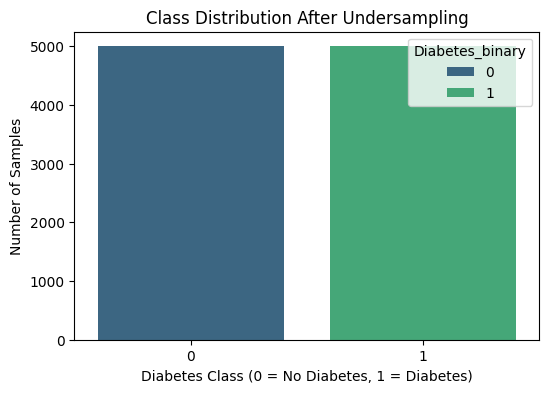

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
95413,1,1,1,-0.138886,0,0,0,1,1,1,...,0,2,-0.483194,-0.602516,0,1,-0.575079,1.095084,1.114489,1
248839,1,1,1,-0.828901,0,0,0,1,1,1,...,0,5,0.353858,-0.020075,0,0,0.473060,1.095084,0.194564,0
115962,1,1,1,-1.242909,0,0,0,1,0,1,...,0,2,-0.483194,-0.602516,0,1,-1.972597,1.095084,1.114489,0
83044,0,0,1,-0.690898,0,0,0,1,1,1,...,0,3,-0.483194,-0.602516,0,1,-1.623217,-0.842946,-1.185323,0
108231,0,0,1,-0.828901,1,1,0,1,1,1,...,0,2,-0.483194,-0.602516,1,1,0.473060,1.095084,-0.725361,0


In [ ]:
 # Plot class distribution after balancing
plt.figure(figsize=(6, 4))
sns.barplot(x=df_balanced[target_col].value_counts().index,
            y=df_balanced[target_col].value_counts().values,
            palette="viridis", hue = df_balanced[target_col].value_counts().index)
plt.xlabel("Diabetes Class (0 = No Diabetes, 1 = Diabetes)")
plt.ylabel("Number of Samples")
plt.title("Class Distribution After Undersampling")
plt.show()

# Display the first few rows of the cleaned and processed dataset
df_balanced.head()

# **Data Split**

In [ ]:
# Define features (X) and target variable (y)
X = df_balanced.drop(columns=["Diabetes_binary"])
y = df_balanced["Diabetes_binary"]

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **Model Definition**

In [ ]:
# Define models
models = {
    "Gaussian Process Classifier": GaussianProcessClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "Gradient Boosting Classifier": GradientBoostingClassifier()
}
#TODO: Tuning
# Dictionary to store results
results = {}

# **Model Training and Evaluation**

In [ ]:
# Train and evaluate each model
for name, model in models.items():
    start_time = time.time()

    # Train the model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For ROC-AUC

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    execution_time = time.time() - start_time

    # Store results
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "ROC-AUC": roc_auc,
        "Time (s)": execution_time
    }

# Convert results into a DataFrame for visualization
results_df = pd.DataFrame(results).T

# **Results**

Model Performance Metrics:
                               Accuracy  Precision  Recall  F1-score   ROC-AUC  \
Gaussian Process Classifier     0.7515   0.728015   0.803  0.763671  0.799165   
Logistic Regression             0.7505   0.736544   0.780  0.757649  0.818801   
Random Forest                   0.7540   0.737383   0.789  0.762319  0.834365   
Support Vector Machine          0.7530   0.727110   0.810  0.766320  0.820730   
Gradient Boosting Classifier    0.7480   0.726277   0.796  0.759542  0.821637   

                                Time (s)  
Gaussian Process Classifier   200.439107  
Logistic Regression             0.086803  
Random Forest                   1.263047  
Support Vector Machine         18.320079  
Gradient Boosting Classifier    1.131432  


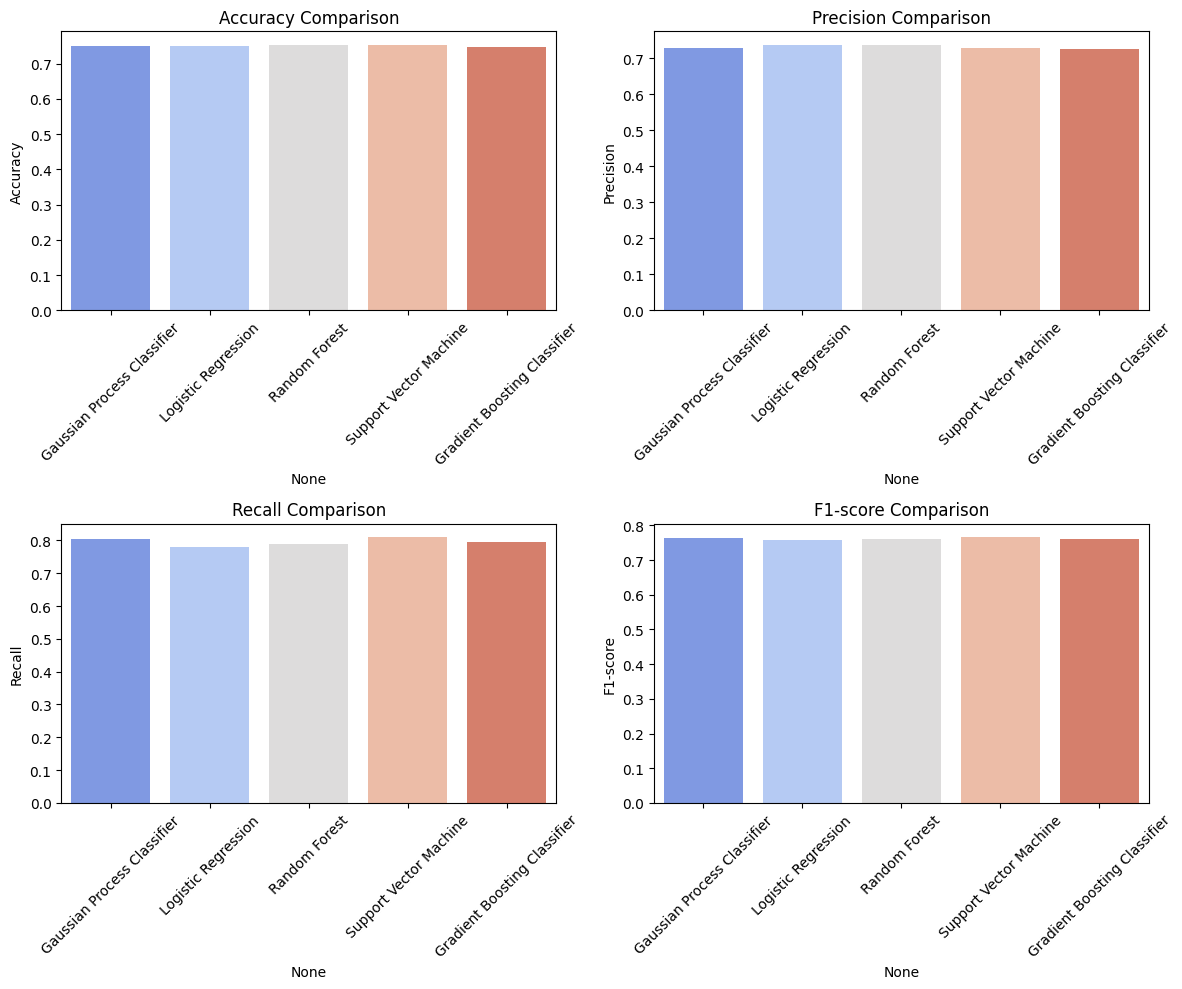


Classification Report for Gaussian Process Classifier:

              precision    recall  f1-score   support

           0       0.78      0.70      0.74      1000
           1       0.73      0.80      0.76      1000

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.77      0.72      0.74      1000
           1       0.74      0.78      0.76      1000

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000


Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.77      0.72      0.75      1000
           1       0.74      0.79      0.76      1000

    accuracy                     

In [ ]:
# Display results
print("Model Performance Metrics:\n", results_df)

# ------------------------- VISUALIZATION -------------------------

# Plot model performance
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

for i, metric in enumerate(metrics):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], hue=results_df.index, palette="coolwarm", legend=False)
    axes[i].set_title(f"{metric} Comparison")
    axes[i].set_ylabel(metric)
    axes[i].set_xticks(range(len(results_df.index)))
    axes[i].set_xticklabels(results_df.index, rotation=45)

plt.tight_layout()
plt.show()

# Display classification reports for each model
for name, model in models.items():
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_test, model.predict(X_test)))

# **Hyperparmeter Tuning on Select Models(Gausian Process Classifier and Logistic Regression)**

In [ ]:
# Define hyperparameter grids
param_grid_gpc = {
    'max_iter_predict': [50, 100, 200],
    'multi_class': ['one_vs_rest']
}

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'saga']
}

# Hyperparameter tuning for Gaussian Process Classifier
gpc = GaussianProcessClassifier()
gpc_search = RandomizedSearchCV(gpc, param_grid_gpc, n_iter=5, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
gpc_search.fit(X_train, y_train)
best_gpc = gpc_search.best_estimator_
print("Best Parameters for Gaussian Process Classifier:", gpc_search.best_params_)

# Hyperparameter tuning for Logistic Regression
lr = LogisticRegression()
lr_search = RandomizedSearchCV(lr, param_grid_lr, n_iter=5, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
lr_search.fit(X_train, y_train)
best_lr = lr_search.best_estimator_
print("Best Parameters for Logistic Regression:", lr_search.best_params_)

# Evaluate tuned models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_pred_proba)
    }

# Store results
results_tuned = {
    "Gaussian Process Classifier (Tuned)": evaluate_model(best_gpc, X_test, y_test),
    "Logistic Regression (Tuned)": evaluate_model(best_lr, X_test, y_test)
}

# Convert results to DataFrame
results_tuned_df = pd.DataFrame(results_tuned).T
print("Tuned Model Performance:\n", results_tuned_df)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for Gaussian Process Classifier: {'multi_class': 'one_vs_rest', 'max_iter_predict': 50}
Best Parameters for Logistic Regression: {'solver': 'saga', 'C': 0.1}
Tuned Model Performance:
                                      Accuracy  Precision  Recall  F1-score  \
Gaussian Process Classifier (Tuned)    0.7515   0.728015   0.803  0.763671   
Logistic Regression (Tuned)            0.7495   0.736493   0.777  0.756204   

                                      ROC-AUC  
Gaussian Process Classifier (Tuned)  0.799165  
Logistic Regression (Tuned)          0.819067  


# **Post-Tuning Results**

In [ ]:
print (results_df, "\n\n",results_tuned_df)

                              Accuracy  Precision  Recall  F1-score   ROC-AUC  \
Gaussian Process Classifier     0.7515   0.728015   0.803  0.763671  0.799165   
Logistic Regression             0.7505   0.736544   0.780  0.757649  0.818801   
Random Forest                   0.7540   0.737383   0.789  0.762319  0.834365   
Support Vector Machine          0.7530   0.727110   0.810  0.766320  0.820730   
Gradient Boosting Classifier    0.7480   0.726277   0.796  0.759542  0.821637   

                                Time (s)  
Gaussian Process Classifier   200.439107  
Logistic Regression             0.086803  
Random Forest                   1.263047  
Support Vector Machine         18.320079  
Gradient Boosting Classifier    1.131432   

                                      Accuracy  Precision  Recall  F1-score  \
Gaussian Process Classifier (Tuned)    0.7515   0.728015   0.803  0.763671   
Logistic Regression (Tuned)            0.7495   0.736493   0.777  0.756204   

                 